# Sales cube in atoti

**Follow along as we build a sales cube on top of automobile Data from the U.S. In this article, learn how to slice and dice the dataset across multiple axes - the customers, the cars, and the brands to find interesting KPIs and summarize the KPIs in an atoti dashboard.**

Sales cubes are used to report on sales transactions, specifically with regard to posting sales order invoices and sales order packing slips. Sales cube datasets are self-containing and do not require users to create table profiles.

**Dataset used:**
The dataset used is synthesized data for for the US automoive industry. There are two main data stores:

* Customer Lever data - demographic information about the customer.
* Car level information - information on the car - the maker, model and the date of purchase etc.

# Loading the data in atoti  

Here we will: 
* load the data in atoti 
* create the customer and cars store
* create a data cube
* define heirarchies, measures and levels.

In [1]:
import atoti as tt
import pandas as pd
import numpy as np

In [2]:
# creating a session - it spins up an in-memory database - similar to Apache Spark - ready to slice’n’dice your big data set.
# In addition to that, it launches a dashboarding Tableau-like web-app

config = {"user_content_storage": "content"}
session = tt.create_session(config=config)

With atoti, you can connect to Azure, AWS and Google Cloud platform to load your data stored in the cloud. 

In [3]:
# loading customer data, load the csv file directly into the store

cust_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-cube/cust_info.csv",
    keys=["customer_id"],
    table_name="customers",
)
cust_store.head()

,sex,age,job,city,state
customer_id,,,,,
11810766,M,55,Graphic designer,Snyderport,Tennessee
3447758,M,50,"Engineer, manufacturing systems",Robertbury,Washington
76264917,M,36,Government social research officer,Davidsonburgh,Tennessee
80827757,F,77,Careers information officer,Briantown,Maine
33384689,M,67,"Sound technician, broadcasting/film/video",Susanberg,Idaho


In [4]:
cars = session.read_csv(
    "s3://data.atoti.io/notebooks/sales-cube/cars_us.csv",
    keys=["customer_id"],
    table_name="cars",
    types={"price": tt.type.DOUBLE},
)

cars.head()

,brand,model,body-type,transmission,fuel,color,date_of_purchase,price,year,type_of_contract
customer_id,,,,,,,,,,
12762620,BMW,Z4,Hatchback,CVT,Diesel,Silver,2018-09-27,50695.0,2018,Leased
10663165,Audi,Q3,Cabriolet,Automatic,Hybrid,Red,2019-05-17,37410.0,2019,Leased
27398081,BMW,3-Series,Coupe,Manual,Hybrid,Navy,2018-01-18,41250.0,2018,Leased
58196946,BMW,4-Series,Sedan,Manual,Hybrid,Black,2018-03-30,45600.0,2018,Leased
38470295,Audi,Q3,Sedan,Automatic,Gasoline,White,2019-11-20,37410.0,2019,Leased


### Join the customer store on the cars cube

In [5]:
cars.join(cust_store)

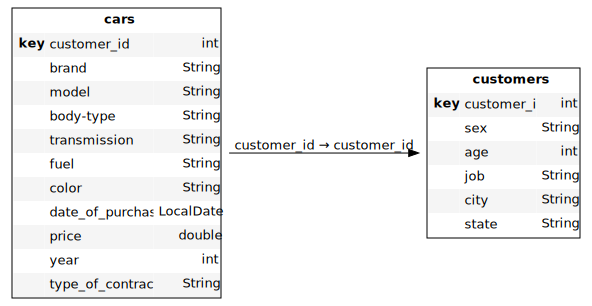

In [6]:
cube = session.create_cube(cars, name="cars")
cube.schema

In [7]:
# defining the measure, level and hierarchy in the cube.

h, l, m = cube.hierarchies, cube.levels, cube.measures

In [8]:
# Here we create levels on date using the 'date_of_purchase'

tt.experimental.create_date_hierarchy(
    "Date",
    cube=cube,
    column=cars["date_of_purchase"],
    levels={"Year": "YYYY", "Quarter": "QQQ", "Month": "MM"},
)

Now, we have the cube with the Yeat Quarter and months as level, are ready to drill down and do the slice and dice along the varioud axis.

# Analysis 1. Number of cars being sold:

The fist analysis concerns the number of cars that have been sold and the value of those cars.
We will slice the number of cars across various axes.  

1.1 - We create a pivot table for the total numbers of cars being sold along with their value drilled down to a month and brand level.

In [9]:
session.visualize("Number of cars sold")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

1.2 - Another aspect to see is to see the number of cars sold for different combinations of Color and Body Type.  
We use the Tree Map available in atoti to visualize these numbers.

In [10]:
session.visualize("car_color_type")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

1.3  - We plot the Body type and Year as clustered columns to see the distribution of the number of cars and their value sold by body type and year of sale.

In [11]:
session.visualize("body_type_year")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

1.4 - We get the number of cars split by whether it was a sold car or a Leased Car and then divided by the fuel type - Diesel, Gasoline or Hybrid.

In [12]:
session.visualize("Sales_contract_and_fuel")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let create a dashboard from the above widgets and summarize the information on the number of cars and their values.

In [13]:
session.link(path="#/dashboard/12f")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

# Analysis 2: Cars sold by brand and model.

In this anaylysis, we will split the sales by the models and see how many cars are sold over time.

2.1 In this analysis, we just slice down the number of cars sold and the their total value by the car model.

In [14]:
session.visualize("units_sold")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

2.2 - Here, we look at the number of cars sold over time - split by the gender of the customer.

In [15]:
session.visualize("monthly_sale_unit")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

2.3 - Here, we look at the total value of cars sold over time - split by the gender of the customer.

In [16]:
session.visualize("monthly_sales_value")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let us summarize this information in another dashboard

In [17]:
session.link(path="#/dashboard/c34")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

# Analysis 3: Customer Level Dashboard 

In this anamysis, we see the numbe of cars sold by customer in different age groups.

### Creating age bucket
We can create new data stores on the go and join them to the origninal cube.
Here we are using creating buckets based on the age of the users.

In [18]:
# age group buckets
age_groups = session.read_pandas(
    pd.DataFrame(
        data=[("0-25Y", i) for i in range(25)]
        + [("25Y - 35Y", i) for i in range(25, 35)]
        + [("35Y - 50Y", i) for i in range(35, 50)]
        + [("50 - 60Y+", i) for i in range(50, 60)]
        + [("60 - 75", i) for i in range(60, 75)]
        + [("75Y+", i) for i in range(75, 200)],
        columns=["age_group", "age"],
    ),
    keys=["age"],
    table_name="age_groups",
)

cust_store.join(age_groups)

In atoti, we can add stores to the cube on the fly and keem doing the slice and dice analysis. Without having to recreate the whe cube.

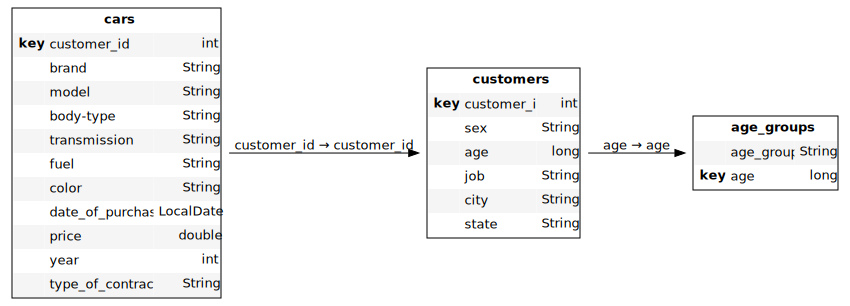

In [19]:
cube.schema

3.1 - Here we plot a radar chart in atoti to see the number of cars sold by the body type.

In [20]:
session.visualize("cars_sold")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

3.2 - To see the number of cars bought by the customer in various age buckets, we plot the bar chart.

In [21]:
session.visualize("age_count")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [22]:
session.visualize("KPIs")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

3.3 - Here, we visualize the timemine for the number of cars sold for different brands. 

In [23]:
session.visualize("Sales_brand")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let us summarize this information in another dashboard on the customer level.

In [24]:
session.link(path="#/dashboard/cca")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.